In [16]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dir = "../../dataset/variance_aug/"
labels = ["canter", "trot", "walk"]

X_list = []
y_list = []

for label in labels:
    for file in sorted(os.listdir(dir + label)):
        var = np.load(dir + label + "/" + file).astype(np.float32)
        var = cv2.resize(var, (128,128), interpolation=cv2.INTER_AREA)
        X_list.append(var)
        y_list.append(label)

X = np.stack(X_list, axis=0)       # shape: (N, 128, 128)

y = np.array(y_list)               # shape: (N,)

N = X.shape[0]
X = X.reshape(N, -1)
        
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6528925619834711


# Torch CNN

### params

In [40]:
dir = "../../dataset/variance_aug/"
labels = ["canter", "trot", "walk"]

rng = 42

epochs = 10

### load arrays

In [41]:
import numpy as np
import os
import cv2

files = sorted(os.listdir(dir))

X_list, y_list = [], []

for label in labels:
    for file in sorted(os.listdir(dir + label)):
        var = np.load(dir + label + "/" + file).astype(np.float32)
        var = cv2.resize(var, (128,128), interpolation=cv2.INTER_AREA)
        X_list.append(var)
        y_list.append(labels.index(label))

X = np.stack(X_list, axis=0)       # shape: (N, 256, 256)
y = np.array(y_list)               # shape: (N,)


### split

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

### tensor
Add channel dimension for CNN

In [43]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [44]:
X_tensor = torch.tensor(X_train[:, None, :, :], dtype=torch.float32)    # insert channels dimention
y_tensor = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [45]:
X_test_tensor = torch.tensor(X_test[:, None, :, :], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


### convolute

In [46]:
import torch.nn as nn

class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 16x128x128
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 16x64x64
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 32x32x32
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 64x16x16
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

num_classes = len(np.unique(y))
model = SmallCNN(num_classes=num_classes)

### learn

In [47]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            test_loss += criterion(preds, yb).item() * xb.size(0)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader):.4f}, Test loss: {test_loss/len(test_dataset):.4f}")
    losses.append([running_loss/len(loader), test_loss/len(test_dataset)])

Epoch 1/10, Loss: 2.4505, Test loss: 0.8394
Epoch 2/10, Loss: 0.7021, Test loss: 0.6974
Epoch 3/10, Loss: 0.5304, Test loss: 0.7090
Epoch 4/10, Loss: 0.3165, Test loss: 0.9777
Epoch 5/10, Loss: 0.2790, Test loss: 0.6550
Epoch 6/10, Loss: 0.1499, Test loss: 0.9057
Epoch 7/10, Loss: 0.1362, Test loss: 0.9445
Epoch 8/10, Loss: 0.1153, Test loss: 1.0193
Epoch 9/10, Loss: 0.0584, Test loss: 0.9178
Epoch 10/10, Loss: 0.3914, Test loss: 0.7030


## Eval

In [48]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []
correct = 0
total = 0
loss_total = 0.0
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        predicted_labels = preds.argmax(dim=1)
        
        all_preds.extend(predicted_labels.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
        
        # Compute loss
        loss = criterion(preds, yb)
        loss_total += loss.item() * xb.size(0)  # sum over batch
        
        # Compute accuracy
        predicted_labels = preds.argmax(dim=1)
        correct += (predicted_labels == yb).sum().item()
        total += yb.size(0)

avg_loss = loss_total / total
accuracy = correct / total

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 0.7030
Test Accuracy: 0.7273


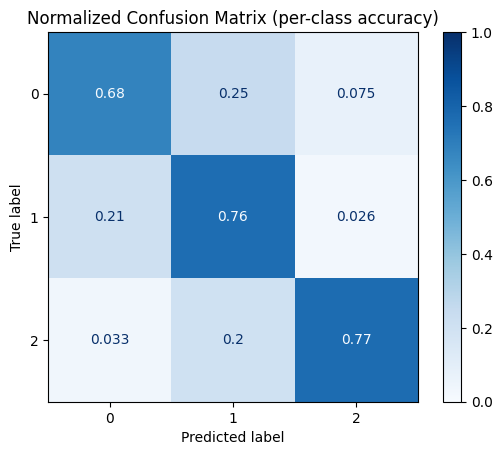

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Suppose all_labels and all_preds are defined
cm = confusion_matrix(all_labels, all_preds)

# Normalize per true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                              display_labels=np.unique(all_labels))
ax = plt.gca()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Stabilize color scale
ax.images[0].set_clim(0, 1)  # force color range 0-1

plt.title("Normalized Confusion Matrix (per-class accuracy)")
plt.show()


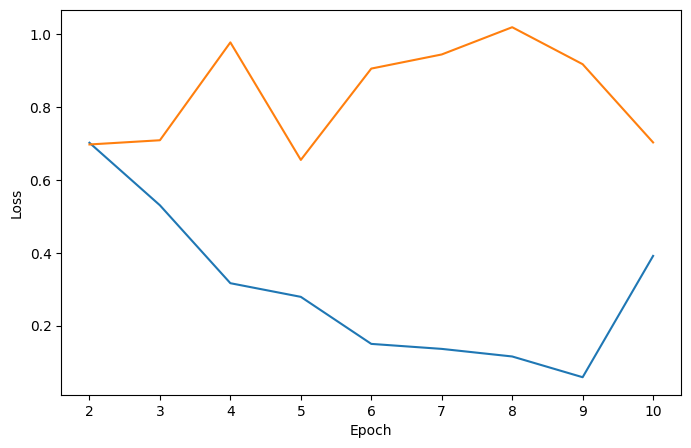

In [50]:
import matplotlib.pyplot as plt

skip = 1

losses_array = np.array(losses)  # shape -> (num_epochs, 2)

# Split columns
train_loss = losses_array[:, 0]
test_loss = losses_array[:, 1]

epochs = range(skip+1, len(train_loss)+1)

fig, ax = plt.subplots(figsize=(8,5))

# Plot loss on left y-axis
ax.plot(epochs, train_loss[skip:], label='Train Loss')
ax.plot(epochs, test_loss[skip:], label='Test Loss')
text = ax.set_xlabel('Epoch')
text = ax.set_ylabel('Loss')




# Save

In [1872]:
torch.save(model.state_dict(), 'model_temp.pth')